In [1]:
import sys

import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

# toolPath = r'/Users/decolvin/Box Sync/UCD_ECO_coding/mypy'
# sys.path.append(toolPath)

import mnv14 as mnv

display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

print(mnv.version)

/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Version 1.4


### Local Data Loading

In [ ]:
filePath = 'data/gbsfkilledvif.xlsx'
data = pd.read_excel(filePath, header=0, index_col=0, parse_date=True, infer_datetime_format=True)
print(data.columns)

### PI Data Loading

In [2]:
from PI_client2 import pi_client
pi = pi_client()

tags = pi.search_by_point('*shields*kbtu*')[0]
#tags += pi.search_by_point('*shields*kbtu*')[0]
for point in tags:
    print(point)


Shields_ChilledWater_Demand_kBtu
Shields_Electricity_Demand_kBtu
Shields_Steam_Demand_kBtu


#### Pull tags

In [3]:
startDate = '2017-01-01'
endDate = '2018-01-01'
interval = '1 hour' #Can be "minute" "hour" "day"
calculation = 'calculated' # Redundant?

data = pi.get_stream_by_point(tags, start=startDate, end=endDate, interval=interval, calculation=calculation)

Shields_ChilledWater_Demand_kBtu                  1 / 3    
Shields_Electricity_Demand_kBtu                   2 / 3    
Shields_Steam_Demand_kBtu                         3 / 3    


# Data Section

Q(75%): 1668.49 Q(25%): 1009.99
IQR value is 658.50
('IQRupper', 4302.5, 'IQRlower', -1624.02)
Ceiling adjusted by IQR - Now 4302.50
OAT being loaded from master file


/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


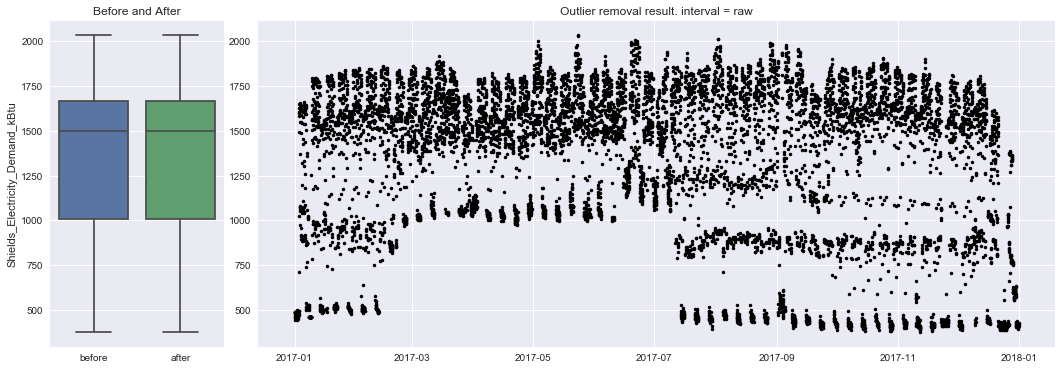

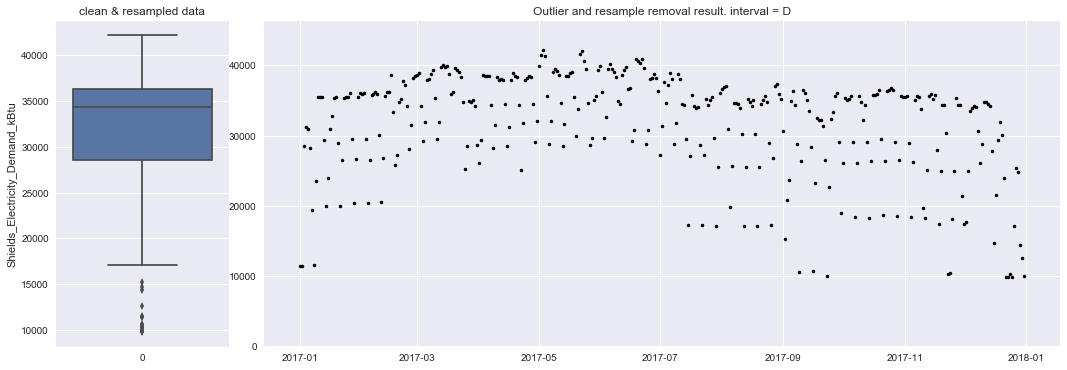

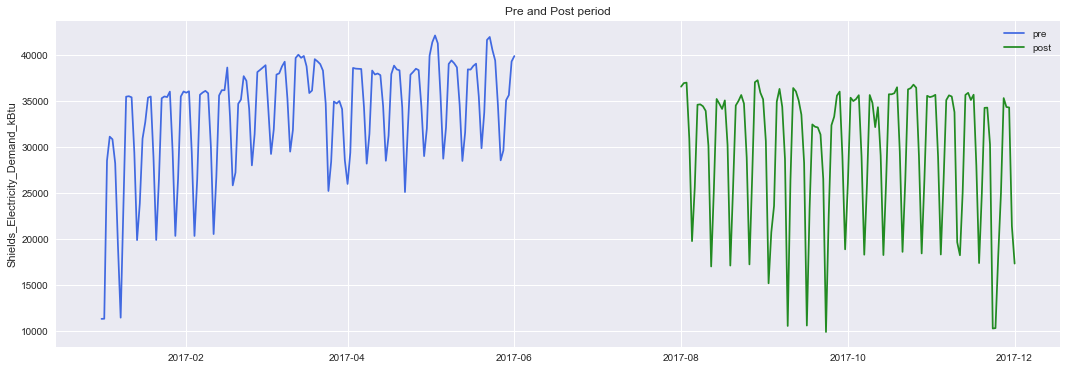

In [4]:
dataParams = {'column': 1,
              'IQRmult' : 4.0,
              'IQR' : 'y', 
              'resampleRate' : 'D', #'D' for daily 'H' for hourly
              'OATsource' : 'file', #'self' or 'file'
              'OATname' : 'OAT', #Name of OAT column if OATsource is 'self'} #only needed with sliceType : 'ranges'
              'sliceType' : 'ranges', #half, middate, ranges
              'midDate' : '2017-01-01', #only needed with sliceType : 'middate'
              'dateRanges' : ['2016-06-01','2017-06-01','2017-08-01','2017-12-01'], #only needed with sliceType : 'ranges'
             }

dk = mnv.data_keeper(data, dataParams)
dk.default_clean()

# Plots
dk._outlier_plot()
dk._resampled_plot(yrange=(-100,dk.modifiedData[dk.com].max()*1.1))
dk._pre_post_plot()

# Many Linear Models

In [ ]:
modelParams = {'params': ['CDH','HDH','month','hour','weekday'],
               'testTrainSplit': 'random',
               'randomState': None,
               'testSize': 0.2,
               'commodityRate': 0.0157,
               'paramPermuteList': ['', 'C(weekday)', 'C(month)']}

allmod = mnv.many_ols(dk.pre, dk.post, modelParams)

allmod.run_all_linear()
print(allmod.statsPool[0:5])
allmod.plot_pool(1)
modelParams['params'] = allmod.statsPool.iloc[0]['params']

# Single Linear Model

In [ ]:
mod = mnv.ols_model(dk.pre, dk.post, modelParams)


mod.model_plot()
mod.calculate_kfold()
mod.calculate_vif()

print(mod.vif[mod.vif['VIF'] > 10])

print('\nKfold')
print(mod.kfoldStats)
print(mod.kfoldRelative)

plt.show() # Show plot before Stats summary
mod.Fit.summary()

### Savings

In [ ]:
print("Savings = $" +str(round(mod.postCumsum * mod.params.commodityRate,1)))
mod.savings_plot(yaxis='dollars')

In [ ]:
mnv.create_archive(dk, mod)
